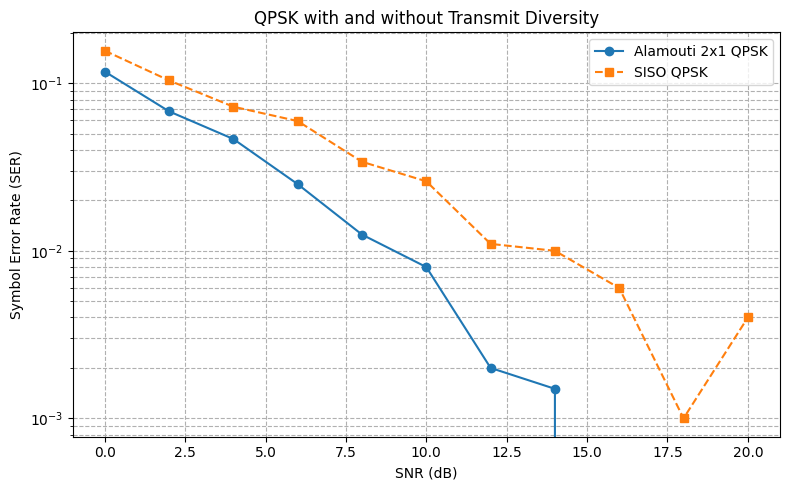

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def qpsk_mod(bits, normalize=True):
    """Map bits to QPSK symbols"""
    symbols = (2 * bits[0::2] - 1) + 1j * (2 * bits[1::2] - 1)
    if normalize:
        symbols /= np.sqrt(2)
    return symbols

def qpsk_demod(symbols):
    """Demap QPSK symbols to bits"""
    bits = np.zeros(2 * len(symbols), dtype=int)
    bits[0::2] = (symbols.real > 0).astype(int)
    bits[1::2] = (symbols.imag > 0).astype(int)
    return bits

def simulate_alamouti_qpsk(num_symbols=1000, snr_db_range=np.arange(0, 21, 2)):
    if num_symbols % 2 != 0:
        num_symbols += 1

    ser = []

    for snr_db in snr_db_range:
        snr_linear = 10**(snr_db / 10)
        noise_variance = 1 / snr_linear

        bits = np.random.randint(0, 2, size=2 * num_symbols)
        symbols = qpsk_mod(bits, normalize=True)

        errors = 0

        for i in range(0, num_symbols, 2):
            s1, s2 = symbols[i], symbols[i + 1]

            # Channel coefficients
            h1 = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
            h2 = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)

            # Alamouti encoding
            x1, x2 = s1, s2
            x3, x4 = -np.conj(s2), np.conj(s1)

            # Noise
            n1 = np.sqrt(noise_variance/2) * (np.random.randn() + 1j * np.random.randn())
            n2 = np.sqrt(noise_variance/2) * (np.random.randn() + 1j * np.random.randn())

            # Received signals
            r1 = h1 * x1 + h2 * x2 + n1
            r2 = h1 * x3 + h2 * x4 + n2

            # Decoding
            s1_hat = np.conj(h1) * r1 + h2 * np.conj(r2)
            s2_hat = np.conj(h2) * r1 - h1 * np.conj(r2)
            denom = np.abs(h1)**2 + np.abs(h2)**2
            s1_hat /= denom
            s2_hat /= denom

            decoded_bits = qpsk_demod(np.array([s1_hat, s2_hat]))
            original_bits = bits[2*i:2*i+4]

            errors += np.sum(decoded_bits != original_bits)

        ser.append(errors / (2 * num_symbols))

    return ser

def simulate_siso_qpsk(num_symbols=1000, snr_db_range=np.arange(0, 21, 2)):
    ser = []

    for snr_db in snr_db_range:
        snr_linear = 10**(snr_db / 10)
        noise_variance = 1 / snr_linear

        bits = np.random.randint(0, 2, size=2 * num_symbols)
        symbols = qpsk_mod(bits, normalize=False)  # No normalization here

        errors = 0

        for i in range(num_symbols):
            s = symbols[i]

            # Rayleigh channel
            h = (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2)
            n = np.sqrt(noise_variance/2) * (np.random.randn() + 1j * np.random.randn())

            # Received signal
            r = h * s + n

            # Equalization
            s_hat = r / h

            decoded_bits = qpsk_demod(np.array([s_hat]))
            original_bits = bits[2*i:2*i+2]
            errors += np.sum(decoded_bits != original_bits)

        ser.append(errors / (2 * num_symbols))

    return ser

# Parameters
snr_db_range = np.arange(0, 21, 2)
num_symbols = 1000

# Run both simulations
ser_alamouti = simulate_alamouti_qpsk(num_symbols, snr_db_range)
ser_siso = simulate_siso_qpsk(num_symbols, snr_db_range)

# Plotting
plt.figure(figsize=(8, 5))
plt.semilogy(snr_db_range, ser_alamouti, 'o-', label='Alamouti 2x1 QPSK')
plt.semilogy(snr_db_range, ser_siso, 's--', label='SISO QPSK')
plt.grid(True, which='both', linestyle='--')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.title('QPSK with and without Transmit Diversity')
plt.legend()
plt.tight_layout()
plt.show()
